## TIA 1A PI - Anaclastic Test
Code developed by Marcelo Prado Cionek from the Federal University of Paraná, Brazil.
Public version made available for the paper 'Targeted iterative assembly and the midpoint method for improved convergence in point-by-point algorithms for freeform generation' by M. Cionek and E. C. Barbano in Optics Continuum.
<br><br>
In this code, TIA is set to generate the anaclastic lens. There are codes to generate vertical, horizontal and absolute errors with respect to the analytical solution.
<br><br>
Contact: marcelo.cionek@ufpr.br (Please indicate TIA in the subject if related)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
import math

In [2]:
#Define the geometric functions
def r(x, x_in, y_in, theta_in):
    return np.tan(theta_in) * (x - x_in) + y_in

def t_N(theta_in, theta_out, n):
    return np.arctan2(np.sin(theta_in)-n*np.sin(theta_out),np.cos(theta_in)-n*np.cos(theta_out))
time_start = time.time()

NR = 200 #Number of rays
n = 2  # Refractive index

thetainit, thetafinal = 1e-12, np.pi/4 #First and last angles
theta_in = np.linspace(thetainit, thetafinal, NR)

x_in = np.linspace(0, 0, NR)  # x-coordinates of the input rays
y_in = np.linspace(0, 0, NR)  # y-coordinates of the input rays

def x_t(x,y,t):
    return 1e30 #Without the setting to angular mode, use a "target at infinity"
def y_t(x,y,t):
    return 0

X_start = 0.25
Y_start = r(X_start,x_in[0],y_in[0],theta_in[0]) #Ensure first vertex is on the first ray.
theta_out_start = np.arctan2(y_t(0,0,theta_in[0])-Y_start,x_t(0,0,theta_in[0])-X_start)

mode = 1#0 for direct, 1 for constant weight
itr = 1 #Number of iterations to solve transcendental equation

w1, w2 = 1, 1 #Initial corner weight
W = w1 + w2

w1f = {"{:.2f}".format(w1)}
w2f = {"{:.2f}".format(w2)}

def TIA_midpoint(theta_in, x_in, y_in, n, num_rays):
    VX = [X_start]
    VY = [(w1*Y_start+w2*r(X_start, x_in[1], y_in[1], theta_in[1]))/W]
    theta_out = []
    for i in range(0,num_rays-1):
        #Get the output angle via trigonometry:
        theta_out.append(np.arctan2(y_t(x_in[i],y_in[i],theta_in[i])-VY[2*i],x_t(x_in[i],y_in[i],theta_in[i])-VX[2*i]))
        theta_N = t_N(theta_in[i],theta_out[i], n)
        tI2 = np.tan(theta_in[i+1])
        tN = 1/np.tan(theta_N)
        #Calculate the next vertex, VX2 via the direct method
        VX2num = VY[2*i]-y_in[i+1] + tI2 * x_in[i+1] + VX[2*i]*tN
        VX2D = VX2num / (tI2 + tN)
        VY2D = tI2 * (VX2D - x_in[i+1]) + y_in[i+1]
        #Using the midpoint transcendental equation, iterate VX2 until it has a satisfactory convergence
        if i < num_rays-2:
            M = VX[2*i]
            VX2=VX2D
            if mode >=1:
                for j in range(0,itr):
                    VY2 = tI2 * (VX2 - x_in[i+1]) + y_in[i+1]
                    theta_out2=np.arctan2(y_t(x_in[i+1],y_in[i+1],theta_in[i+1])-VY2,x_t(x_in[i+1],y_in[i+1],theta_in[i+1])-VX2)
                    tN2 = 1/np.tan(t_N(theta_in[i+1], theta_out2, n))
                    VX2=(y_in[i+1]-VY[-1]-tN2*VX[-1]-tI2*x_in[i+1])/(-tN2-tI2)
                VY2 = tI2 * (VX2 - x_in[i+1]) + y_in[i+1]
                tN2 = 1/np.tan(t_N(theta_in[i+1], theta_out2, n))
                #Intercept with next ray to get midpoint
                tI3 = np.tan(theta_in[i+2])
                VX3num = VY2-y_in[i+2] + tI3*x_in[i+2] + VX2*tN2
                VX3D = VX3num / (tI3 + tN2)
                VX2f = (VX3D+VX2)/2
                VY2f = -tN2*(VX2f-VX[2*i])+VY[2*i]
                VX.append(VX2)
                VY.append(VY2)
                VX.append(VX2f)
                VY.append(VY2f)
        else:
            VY2D = tI2 * (VX2D - x_in[i+1]) + y_in[i+1]
            VXmid = (VX2D+VX[2*i])/2
            VYmid = -tN*(VXmid-VX[-1])+VY[-1]
            VX.append(VXmid)
            VY.append(VYmid)
            VX.append(VX2D)
            VY.append(VY2D)
        theta_out.append(np.arctan2(y_t(x_in[-1],y_in[-1],theta_in[-1])-VY[-1],x_t(x_in[-1],y_in[-1],theta_in[-1])-VX[-1]))
    return VX, VY, theta_out

VX, VY, theta_out = TIA_midpoint(theta_in, x_in, y_in, n, NR)

time_data = time.time()
print(f"Time to calculate TIA-m solution points for {NR} rays:",time_data-time_start,"seconds")

def TIA_direct(theta_in, x_in, y_in, n, num_rays):
    VXD = [X_start]
    VYD = [(w1*Y_start+w2*r(X_start, x_in[1], y_in[1], theta_in[1]))/W]
    theta_outD = []
    for i in range(0,num_rays-1):
        theta_outD.append(np.arctan2(y_t(x_in[i],y_in[i],theta_in[i])-VYD[i],x_t(x_in[i],y_in[i],theta_in[i])-VXD[i]))
        theta_N = t_N(theta_in[i],theta_outD[i], n)
        tI2 = np.tan(theta_in[i+1])
        tN = 1/np.tan(theta_N)
        #Calculate the next vertex, VX2 via the direct method
        VX2num = VYD[-1]-y_in[i+1] + tI2 * x_in[i+1] + VXD[-1]*tN
        VX2D = VX2num / (tI2 + tN)
        VY2D = -tN*(VX2D - VXD[-1]) + VYD[-1]
        VXD.append(VX2D)
        VYD.append(VY2D)
    return VXD, VYD, theta_outD

VXD, VYD, theta_outD = TIA_direct(theta_in, x_in, y_in, n, NR)

time_data2 = time.time()-time_data
print(f"Time to calculate TIA-d solution points for {NR} rays:",time_data2,"seconds")
#print(NR, time_data2, time_data-time_start)
iteratetxt = f"(Iterations: {itr})" if mode >= 1 else ""
tintstr, tfinalstr = str(thetainit),str(thetafinal)
tintstr, tfinalstr = tintstr[:5], tfinalstr[:5]

Time to calculate TIA-m solution points for 200 rays: 0.04867744445800781 seconds
Time to calculate TIA-d solution points for 200 rays: 0.011530876159667969 seconds


<ipython-input-3-1d6beca04af6>:44: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(VX, VY, 'r-', label='Solution', linewidth=2, linestyle='--', zorder=2)


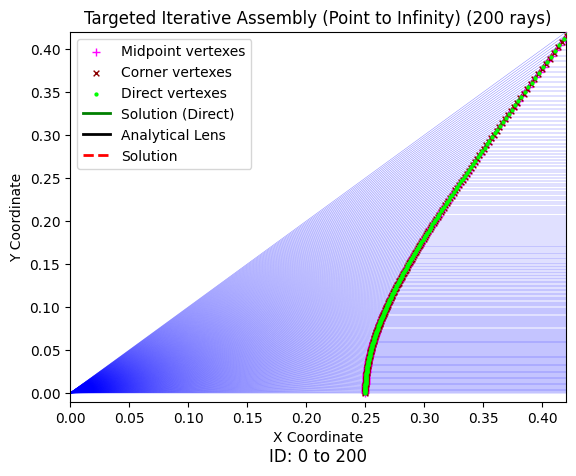

Time to plot 7.642868518829346 seconds


In [3]:
'Plot the solution'
VXm, VXc, VYm, VYc = [X_start],[],[Y_start],[]
for i in range(0,NR-1):
    VXc.append(VX[2*i])
    VYc.append(VY[2*i])
    VXm.append(VX[2*i+1])
    VYm.append(VY[2*i+1])

time_plot = time.time()

plt.scatter(VXm, VYm, color ='magenta', label = "Midpoint vertexes", s=150/np.cbrt(NR), linewidth=1, marker ="+",zorder=3)
plt.scatter(VXc, VYc, color ='darkred', label = "Corner vertexes", s=100/np.cbrt(NR), linewidth=1, marker ="x",zorder=3)
for i in range(NR):
    x_range_in = np.linspace(x_in[i], VXm[i], 100)
    x_range_out = np.linspace(VXm[i], VXm[-1], 100)
    plt.plot(x_range_in, r(x_range_in, x_in[i], y_in[i],theta_in[i]), 'b-',linewidth=2/np.cbrt(NR), alpha=0.5)
    plt.plot(x_range_out, r(x_range_out, VXm[i], VYm[i],theta_out[i]), linestyle = '-', color = 'blue',linewidth=2/np.cbrt(NR), alpha=0.5)
plt.scatter(VXD, VYD, label = 'Direct vertexes', color ='lime', s=25/np.cbrt(NR), marker ="o",zorder=3)
plt.plot(VXD, VYD, color = 'green', label='Solution (Direct)', linewidth=2)

num_VXD = len([x for x in VXD if not math.isnan(x)])
if num_VXD ==len(VXD):
    err = ""
else:
    err = f", (no. errors: {NR-num_VXD})"
##

def ana(x,n,V):
    return np.sqrt((n**2-1)*(-x+n/(n+1)*abs(V))**2+V**2*(1-n)/(n+1))

def ana_inv(y,n,V):
    return n/(n+1)*abs(V)+np.sqrt(1/(n**2-1)*(y**2+V**2*(n-1)/(n+1)))
#For debugging, select these vertex IDs
ID = 0 #inital
DD = NR #increment
plt.xlim(left=VX[ID],right=VX[ID+DD])
plt.ylim(bottom=VY[ID],top=VY[ID+DD])
plt.text(0.5, -0.15, fr"ID: {ID} to {ID+DD}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)
x_sol = np.linspace(VX[ID],VX[ID+DD],20*NR)

#x_sol = np.linspace(VX[0],np.max(VX),20*NR)
plt.plot(x_sol, ana(x_sol,n,VX[0]), 'black', label='Analytical Lens', linewidth=2, zorder=1)

plt.plot(VX, VY, 'r-', label='Solution', linewidth=2, linestyle='--', zorder=2)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Targeted Iterative Assembly (Point to Infinity) ({NR} rays)')
plt.legend()

plt.xlim(left=0,right=0.42)
plt.ylim(bottom=-0.01,top=0.42)

closeup = False
if closeup == True:
    S_x, S_y = 0.05, 0.05
    S_h, S_v = S_x*(VX[-1]-VX[0]), S_y*(VY[-1]-VY[0])
    plt.xlim(left=VX[0]-S_h,right=VX[-1]+S_h)
    plt.ylim(bottom=VY[0]-S_v,top=VY[-1]+S_v)

#    plt.grid(True)

iteratetxt = f"(Analytical iterations - {itr})" if mode >= 1 else ""
tintstr, tfinalstr = str(thetainit),str(thetafinal)
tintstr, tfinalstr = tintstr[:5], tfinalstr[:5]

#plt.text(0.5, -0.15, fr'$\theta_i$ = {tintstr}, $\theta_f$ = {tfinalstr} | {iteratetxt}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

#plt.savefig(f'TIA 1A PI (ID {ID} to {ID+DD}) (N={NR}).png', dpi=400, bbox_inches='tight', transparent=True)
plt.show()
print("Time to plot",time.time()-time_plot,"seconds")

In [4]:
'Vertical error calculation'

y_dif = []
for i in range(1,len(VX)):
    y_dif.append(abs(ana(VX[i], n, VX[0]) - VY[i]))

y_dif2 = []
for i in range(1,len(VXD)):
    y_dif2.append(abs(ana(VXD[i], n, VXD[0]) - VYD[i]))

pts = 200000
x_cont = np.linspace(np.min(VX), np.max(VX), pts)
# Interpolate the piecewise linear function S(X)
s_d = interp1d(VXD, VYD, kind='linear', fill_value="extrapolate")
s_m = interp1d(VX, VY, kind='linear', fill_value="extrapolate")

# Calculate the difference between s_interpolated and perfect for each x in x_range
def y_dif_cont1(x):
    return abs(ana(x, n, VX[0])-s_m(x))
def y_dif_cont2(x):
    return abs(ana(x, n, VXD[0])-s_d(x))

Direct Vertex Mean: 5.65e-04
Midpoint Vertex Mean: 2.43e-06
Direct Segment Mean: 6.26e-04
Midpoint Segment Mean: 1.67e-06


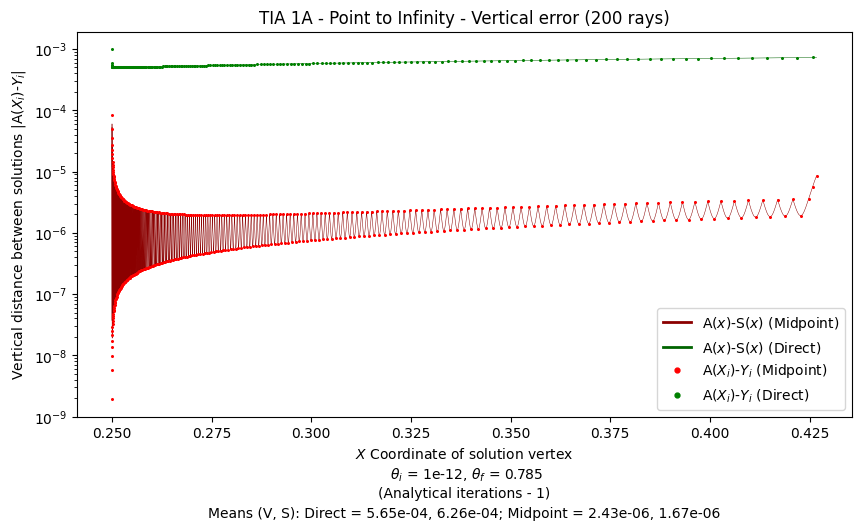

In [10]:
'Vertical error plot'

plt.figure(figsize=(10, 5))
plt.plot(x_cont[1:], y_dif_cont1(x_cont[1:]), color='darkred', linewidth=5/np.sqrt(NR), zorder=1)
plt.plot(x_cont[1:], y_dif_cont2(x_cont[1:]), color='darkgreen', linewidth=5/np.sqrt(NR), zorder=1)
plt.scatter(VX[1:], y_dif, color = "red", s=20/np.sqrt(NR), zorder=2)
plt.scatter(VXD[1:], y_dif2, color = "green", s=20/np.sqrt(NR), zorder=2)

lmid_legend = plt.Line2D([0], [0], linewidth=2, color='darkred', label=f'A($x$)-S($x$) (Midpoint)')
ldir_legend = plt.Line2D([0], [0], linewidth=2, color='darkgreen', label=f'A($x$)-S($x$) (Direct)')
smid_legend = plt.Line2D([0], [0], marker='.', markersize=7, color='red', linestyle='None', label=fr'A($X_i$)-$Y_i$ (Midpoint)')
sdir_legend = plt.Line2D([0], [0], marker='.', markersize=7, color='green', linestyle='None', label=fr'A($X_i$)-$Y_i$ (Direct)')
plt.legend(handles=[lmid_legend, ldir_legend, smid_legend, sdir_legend])

plt.xlabel('$X$ Coordinate of solution vertex')
plt.ylabel(fr'Vertical distance between solutions |A($X_i$)-$Y_i$|')
plt.title(fr'TIA 1A - Point to Infinity - Vertical error ({NR} rays)')

plt.yscale('log')

v_M = np.mean(np.abs(y_dif))
v_D = np.mean(np.abs(y_dif2))
v_Ms = "{:.2e}".format(v_M)
v_Ds = "{:.2e}".format(v_D)
print("Direct Vertex Mean:", v_Ds)
print("Midpoint Vertex Mean:", v_Ms)

s_M = np.mean(np.abs(y_dif_cont1(x_cont[1:-1])))
s_D = np.mean(np.abs(y_dif_cont2(x_cont[1:-1])))
s_Ms = "{:.2e}".format(s_M)
s_Ds = "{:.2e}".format(s_D)
print("Direct Segment Mean:", s_Ds)
print("Midpoint Segment Mean:", s_Ms)

plt.text(0.5, -0.15, fr' $\theta_i$ = {tintstr}, $\theta_f$ = {tfinalstr}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.20, fr'{iteratetxt}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.25, fr'Means (V, S): Direct = {v_Ds}, {s_Ds}; Midpoint = {v_Ms}, {s_Ms}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
#plt.savefig(f'TIA 1A PI Vertical Log Error N={NR}.png', dpi=400, bbox_inches='tight', transparent=True)
plt.show()

In [6]:
'Horizontal error calculation'
x_dif_mid = []
for i in range(1,len(VY)):
    x_dif_mid.append(abs(ana_inv(VY[i], n, VX[0]) - VX[i]))

x_dif_dir = []
for i in range(1,len(VYD)):
    x_dif_dir.append(abs(ana_inv(VYD[i], n, VXD[0]) - VXD[i]))

s_m_inv = interp1d(VY, VX, kind='linear', fill_value="extrapolate")
s_d_inv = interp1d(VYD, VXD, kind='linear', fill_value="extrapolate")

pts = 200000
y_cont = np.linspace(np.min(VY), np.max(VY), pts)

# Calculate the difference between s_interpolated and perfect for each x in x_range
def x_dif_cont_mid(y):
    return abs(ana_inv(y, n, VX[0])-s_m_inv(y))
def x_dif_cont_dir(y):
    return abs(ana_inv(y, n, VXD[0])-s_d_inv(y))

Direct Vertex Mean: 1.93e-04
Midpoint Vertex Mean: 5.73e-07
Direct Segment Mean: 2.59e-04
Midpoint Segment Mean: 6.91e-07


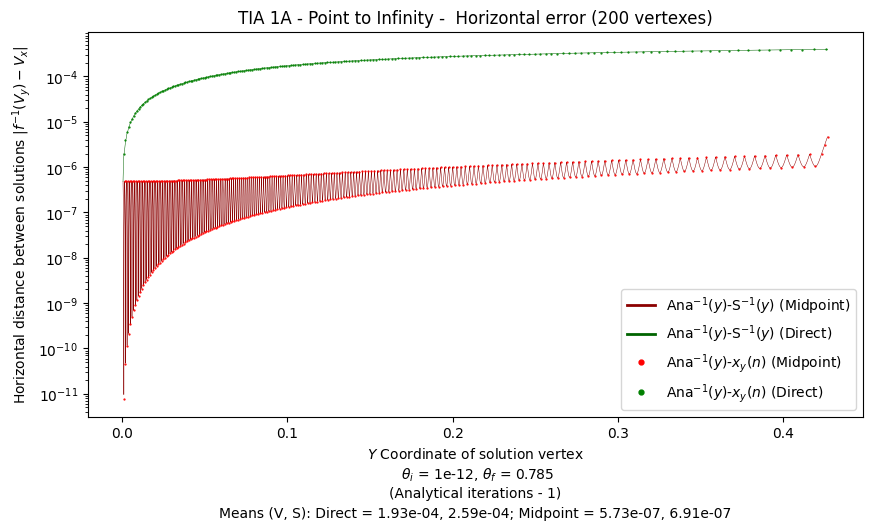

In [9]:
'Horizontal error plot'

plt.figure(figsize=(10, 5))
plt.plot(y_cont, x_dif_cont_mid(y_cont), linewidth=5/np.sqrt(NR),color = "darkred", zorder=1)
plt.plot(y_cont, x_dif_cont_dir(y_cont), linewidth=5/np.sqrt(NR),color = "darkgreen", zorder=1)
plt.scatter(VY[1:], x_dif_mid,marker ='.',color = "red", s=20/np.sqrt(NR), zorder=2)
plt.scatter(VYD[1:], x_dif_dir,marker='.', color = "green", s=20/np.sqrt(NR), zorder=2)

lmid_legend = plt.Line2D([0], [0], linewidth=2, color='darkred', label=f'Ana$^{{-1}}$($y$)-S$^{{-1}}$($y$) (Midpoint)')
ldir_legend = plt.Line2D([0], [0], linewidth=2, color='darkgreen', label=f'Ana$^{{-1}}$($y$)-S$^{{-1}}$($y$) (Direct)')
smid_legend = plt.Line2D([0], [0], marker='.', markersize=7, color='red', linestyle='None', label=fr'Ana$^{{-1}}$($y$)-$x_y(n)$ (Midpoint)')
sdir_legend = plt.Line2D([0], [0], marker='.', markersize=7, color='green', linestyle='None', label=fr'Ana$^{{-1}}$($y$)-$x_y(n)$ (Direct)')
plt.legend(handles=[lmid_legend, ldir_legend, smid_legend, sdir_legend])

plt.xlabel(fr'$Y$ Coordinate of solution vertex')
plt.yscale('log')
plt.ylabel(fr'Horizontal distance between solutions |$f^{{-1}}(V_y)-V_x$|')
plt.title(f'TIA 1A - Point to Infinity -  Horizontal error ({NR} vertexes)')
#plt.grid(True)

v_M = np.mean(np.abs(x_dif_mid))
v_D = np.mean(np.abs(x_dif_dir))
v_Ms = "{:.2e}".format(v_M)
v_Ds = "{:.2e}".format(v_D)
print("Direct Vertex Mean:", v_Ds)
print("Midpoint Vertex Mean:", v_Ms)

s_M = np.mean(np.abs(x_dif_cont_mid(y_cont[1:-1])))
s_D = np.mean(np.abs(x_dif_cont_dir(y_cont[1:-1])))
s_Ms = "{:.2e}".format(s_M)
s_Ds = "{:.2e}".format(s_D)
print("Direct Segment Mean:", s_Ds)
print("Midpoint Segment Mean:", s_Ms)

plt.text(0.5, -0.15, fr' $\theta_i$ = {tintstr}, $\theta_f$ = {tfinalstr}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.20, fr'{iteratetxt}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.25, fr'Means (V, S): Direct = {v_Ds}, {s_Ds}; Midpoint = {v_Ms}, {s_Ms}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

#plt.savefig(f'TIA 1A PI Horizontal Log Error N={NR} Init Weights (w1={w1} and w2={w2f}.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

Direct Vertex Mean: 3.44e-04
Midpoint Vertex Mean: 5.43e-07


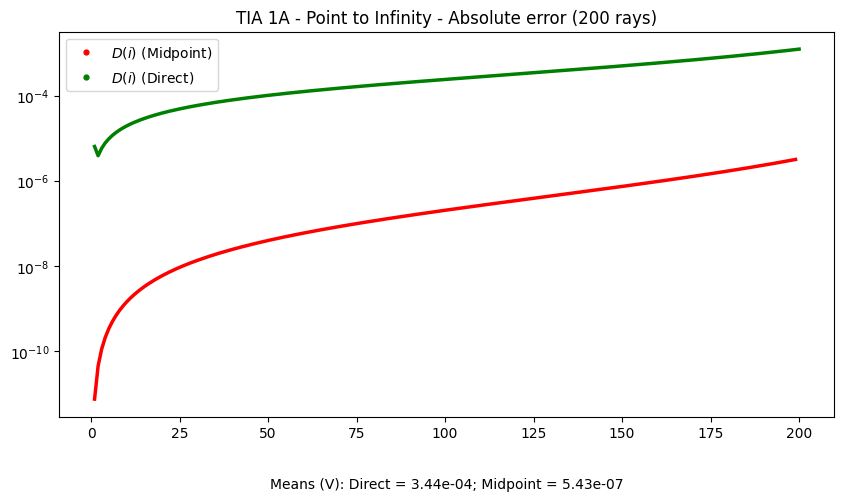

In [8]:
'Absolute error'
RVX = []
RVY = []
DM = []
DD = []
V = X_start
for i in range(1,NR):
    A = np.tan(theta_in[i])
    X = x_in[i]
    Y = y_in[i]
    a = 1 + A**2-n**2
    b = A**2*X-A*Y-n*(n-1)*V
    c = A**2*X**2+Y**2-2*A*X*Y-(n-1)**2*V**2
    RVX.append((b-np.sign(V)*np.sqrt(b**2-a*c))/a)
    RVY.append(r(RVX[-1],X,Y,theta_in[i]))
    DM.append(np.sqrt((RVX[-1]-VX[2*i-1])**2+(RVY[-1]-VY[2*i-1])**2))
    DD.append(np.sqrt((RVX[-1]-VXD[i])**2+(RVY[-1]-VYD[i])**2))
num = np.linspace(1,NR,NR-1)

plt.figure(figsize=(10, 5))

DM = DM[:-1]
numa = num[:-1]
plt.plot(numa, DM, linewidth=2.5,color = "red", zorder=1)
plt.plot(num, DD, linewidth=2.5,color = "green", zorder=1)

emid = plt.Line2D([0], [0], marker='.', markersize=7, color='red', linestyle='None', label=f'$D(i)$ (Midpoint)')
edir = plt.Line2D([0], [0], marker='.', markersize=7, color='green', linestyle='None', label=f'$D(i)$ (Direct)')
plt.legend(handles=[emid, edir])

#plt.xlabel(fr'Ray ID')
plt.yscale('log')
#plt.ylabel(fr'Distance between intercepts |$V_{{TIA}}$-$V_{{Ana}}$|')
plt.title(f'TIA 1A - Point to Infinity - Absolute error ({NR} rays)')

v_M = np.mean(np.abs(DM))
v_D = np.mean(np.abs(DD))
v_Ms = "{:.2e}".format(v_M)
v_Ds = "{:.2e}".format(v_D)
print("Direct Vertex Mean:", v_Ds)
print("Midpoint Vertex Mean:", v_Ms)

plt.text(0.5, -0.175, fr'Means (V): Direct = {v_Ds}; Midpoint = {v_Ms}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

#plt.savefig(f'TIA 1A PI Absolute Log Error N={NR} Init Weights (w1={w1} and w2={w2f}.png', dpi=400, bbox_inches='tight', transparent=True)
plt.show()